# Time Series Forecasting for BTC Prices


This notebook predicts the next 7 days of BTC closing prices using the provided dataset. Steps include:
1. Loading and preprocessing the data.
2. Visualizing the time series.
3. Building a predictive model (e.g., ARIMA, LSTM).
4. Forecasting the next 7 days.


In [17]:
import pandas as pd

# Load the data from the uploaded file
file_path = 'Bitcoin.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

from datetime import datetime

# Rename 'Harga Penutupan (USD)' for easier processing
data.rename(columns={'Harga Penutupan (USD)': 'Harga_Penutupan'}, inplace=True)

# Ensure the data is sorted by time
data = data.sort_values(by='Waktu')

# Display basic info of processed data
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 0 to 984
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   _id              988 non-null    object 
 1   Waktu            988 non-null    object 
 2   Harga_Penutupan  988 non-null    float64
dtypes: float64(1), object(2)
memory usage: 30.9+ KB


(None,
                         _id             Waktu  Harga_Penutupan
 0  6746f698c8fc5b6acaad4045  2024-11-20 13:20         94362.22
 1  6746f698c8fc5b6acaad4044  2024-11-20 13:30         94273.24
 2  6746f698c8fc5b6acaad4043  2024-11-20 13:40         94599.33
 3  6746f698c8fc5b6acaad4042  2024-11-20 13:50         94483.50
 4  6746f698c8fc5b6acaad4041  2024-11-20 14:00         94531.35)

In [18]:
data['Waktu'] = pd.to_datetime(data['Waktu'], errors='coerce')

Epoch 1/50


C:\Users\cuzt2\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - loss: 0.3318 - val_loss: 0.1776 - learning_rate: 0.0010
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0103 - val_loss: 0.1561 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0100 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0047 - val_loss: 0.1477 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0061 - val_loss: 0.1342 - learning_rate: 0.0010
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0039 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0038 - val_loss: 0.1010 - learning_rate: 0.0010
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0038 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0043 - val_loss: 0.0666 - learning_rate: 0.0010
Epoch 10/50
19/19 ━━

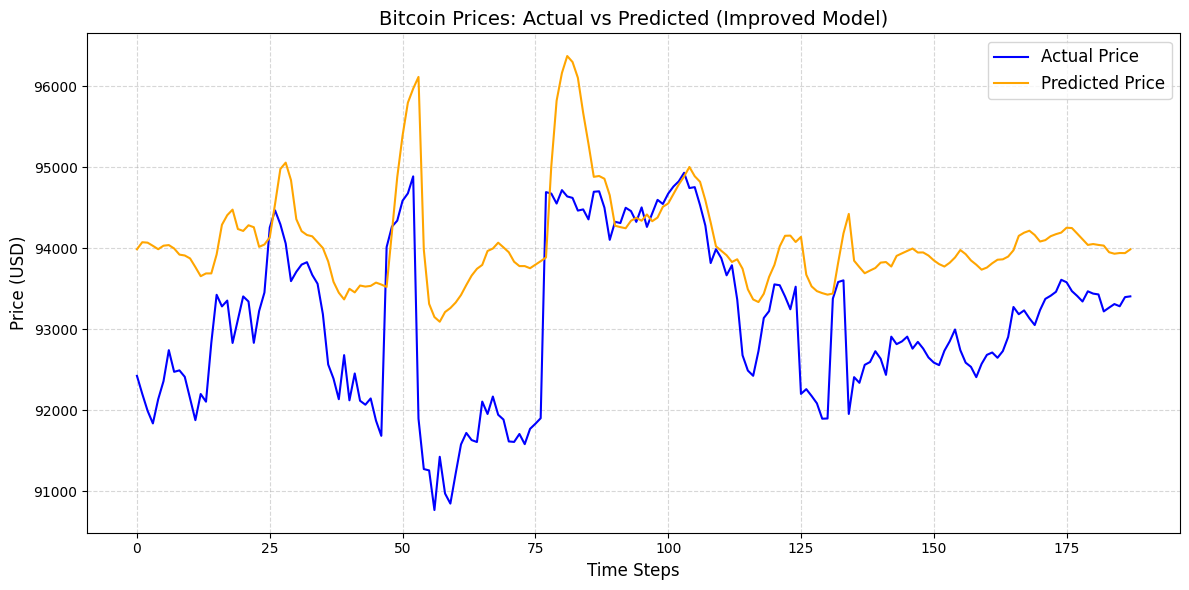

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
df = pd.read_csv('bitcoin.csv')
df.set_index('Waktu', inplace=True)
prices = data['Harga_Penutupan'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Step 2: Create sequences
sequence_length = 50

def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x, y = create_sequences(prices_scaled, sequence_length)

split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Step 3: Define the model
model_improved = Sequential([
    Bidirectional(LSTM(256, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))),
    Dropout(0.05),  # Dropout lebih kecil untuk sensitivitas
    BatchNormalization(),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True)),
    Dropout(0.05),
    BatchNormalization(),
    LSTM(64, activation='tanh'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer
])
model_improved.compile(optimizer='adam', loss='mean_squared_error')


# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Step 2: Train the improved model
history_improved = model_improved.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predict on test data
y_pred_scaled_improved = model_improved.predict(x_test)
y_pred_improved = scaler.inverse_transform(y_pred_scaled_improved)
y_test_actual_improved = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae_improved = mean_absolute_error(y_test_actual_improved, y_pred_improved)
print(f"Mean Absolute Error (Improved Model): {mae_improved}")

# Step 4: Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual_improved)), y_test_actual_improved, label='Actual Price', color='blue')
plt.plot(range(len(y_pred_improved)), y_pred_improved, label='Predicted Price', color='orange')
plt.title('Bitcoin Prices: Actual vs Predicted (Improved Model)', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

                  Time  Predicted Price (USD)
0  2024-11-29 00:00:00           94024.890625
1  2024-11-29 01:00:00           94303.546875
2  2024-11-29 02:00:00           94598.062500
3  2024-11-29 03:00:00           95041.203125
4  2024-11-29 04:00:00           95613.179688
5  2024-11-29 05:00:00           96325.656250
6  2024-11-29 06:00:00           97036.007812
7  2024-11-29 07:00:00           97416.343750
8  2024-11-29 08:00:00           97623.007812
9  2024-11-29 09:00:00           97713.820312
10 2024-11-29 10:00:00           97742.015625
11 2024-11-29 11:00:00           97717.257812
12 2024-11-29 12:00:00           97649.312500
13 2024-11-29 13:00:00           97541.781250
14 2024-11-29 14:00:00           97392.960938
15 2024-11-29 15:00:00           97237.773438
16 2024-11-29 16:00:00           97065.265625
17 2024-11-29 17:00:00           96903.851562
18 2024-11-29 18:00:00           96767.703125
19 2024-11-29 19:00:00           96635.867188
20 2024-11-29 20:00:00           9

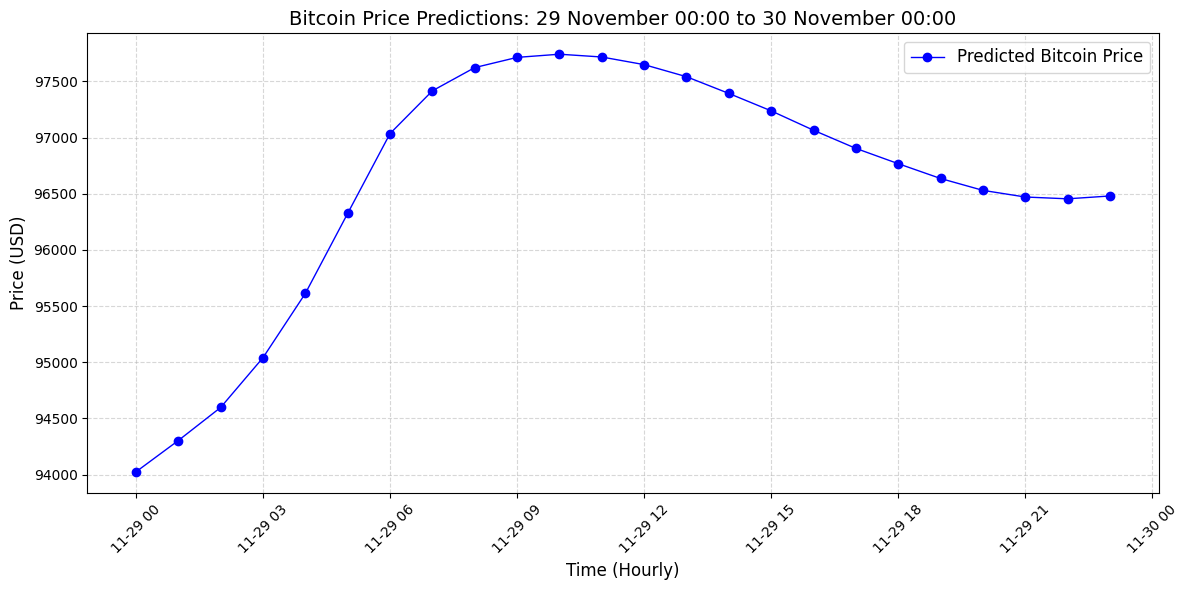

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Siapkan data terakhir untuk prediksi
sequence_length = 100  # Panjang sequence (sama seperti saat training)
future_steps = 24  # Prediksi untuk 24 jam
# Data terakhir sebagai input
last_sequence = prices_scaled[-sequence_length:].reshape(1, sequence_length, 1)

# Prediksi untuk 24 jam
predicted_prices_scaled = []
for _ in range(24):
    prediction = model_improved.predict(last_sequence, verbose=0)
    predicted_prices_scaled.append(prediction[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Kembalikan ke skala asli
predictions = scaler.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1))


# Step 4: Buat timestamp untuk 28 November
start_time = pd.Timestamp("2024-11-29 00:00:00")  # Mulai dari jam 00:00
future_times = [start_time + pd.Timedelta(hours=i) for i in range(future_steps)]  # Buat jam tiap jam

# Step 5: Gabungkan prediksi dengan timestamp
predictions_df = pd.DataFrame({
    'Time': future_times,
    'Predicted Price (USD)': predictions.flatten()
})

# Step 6: Tampilkan hasil prediksi
print(predictions_df)

# Step 7: Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Time'], predictions_df['Predicted Price (USD)'], marker='o', label='Predicted Bitcoin Price', color='blue', linewidth=1)
plt.title('Bitcoin Price Predictions: 29 November 00:00 to 30 November 00:00', fontsize=14)
plt.xlabel('Time (Hourly)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [34]:
pip install keras-tuner --upgrade


  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Define the model for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    # Add first Bidirectional LSTM layer
    model.add(
        Bidirectional(
            LSTM(
                hp.Int('lstm_units_1', min_value=64, max_value=512, step=64), 
                activation='tanh', 
                return_sequences=True, 
                input_shape=(x_train.shape[1], x_train.shape[2])
            )
        )
    )
    model.add(Dropout(hp.Float('dropout_1', min_value=0.05, max_value=0.5, step=0.05)))
    model.add(BatchNormalization())

    # Add second Bidirectional LSTM layer
    model.add(
        Bidirectional(
            LSTM(
                hp.Int('lstm_units_2', min_value=32, max_value=256, step=32),
                activation='tanh',
                return_sequences=False
            )
        )
    )
    model.add(Dropout(hp.Float('dropout_2', min_value=0.05, max_value=0.5, step=0.05)))

    # Dense layers
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='mean_squared_error'
    )
    return model

# Step 2: Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='hyperparam_tuning',  # Directory to save logs
    project_name='bitcoin_lstm_tuning'
)

# Step 3: Run the hyperparameter search
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Step 4: Get the best hyperparameters and rebuild the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of LSTM units in the first layer is {best_hps.get('lstm_units_1')}.
The optimal number of LSTM units in the second layer is {best_hps.get('lstm_units_2')}.
The optimal dropout rates are {best_hps.get('dropout_1')} and {best_hps.get('dropout_2')}.
The optimal number of dense units is {best_hps.get('dense_units')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Step 5: Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Step 6: Train the best model
history = best_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Step 7: Evaluate the best model
y_pred_scaled_best = best_model.predict(x_test)
y_pred_best = scaler.inverse_transform(y_pred_scaled_best)
y_test_actual_best = scaler.inverse_transform(y_test.reshape(-1, 1))

mae_best = mean_absolute_error(y_test_actual_best, y_pred_best)
print(f"Mean Absolute Error (Best Model): {mae_best}")


Trial 10 Complete [00h 03m 41s]
val_loss: 0.02201768383383751

Best val_loss So Far: 0.009972556494176388
Total elapsed time: 00h 25m 54s

The optimal number of LSTM units in the first layer is 192.
The optimal number of LSTM units in the second layer is 224.
The optimal dropout rates are 0.2 and 0.1.
The optimal number of dense units is 32.
The optimal learning rate is 0.005589257943589798.

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.1842 - val_loss: 0.0606
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0144 - val_loss: 0.0578
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0105 - val_loss: 0.0673
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0099 - val_loss: 0.0800
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0094 - val_loss: 0.0749
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0050 - val_loss: 0.0718
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0052 - val_loss: 0.0747
6/

Epoch 1/50


C:\Users\cuzt2\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - loss: 10.1489 - val_loss: 0.3590
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 0.0289 - val_loss: 0.1622
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 0.0197 - val_loss: 0.1481
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 0.0153 - val_loss: 0.1469
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 0.0150 - val_loss: 0.1087
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0150 - val_loss: 0.0236
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 0.0129 - val_loss: 0.0615
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 0.0144 - val_loss: 0.0271
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - loss: 0.0105 - val_loss: 0.0702
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 0.0106 - val_loss: 0.0624
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0099 - val_loss: 0.0645
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Mean Absolute Error (B

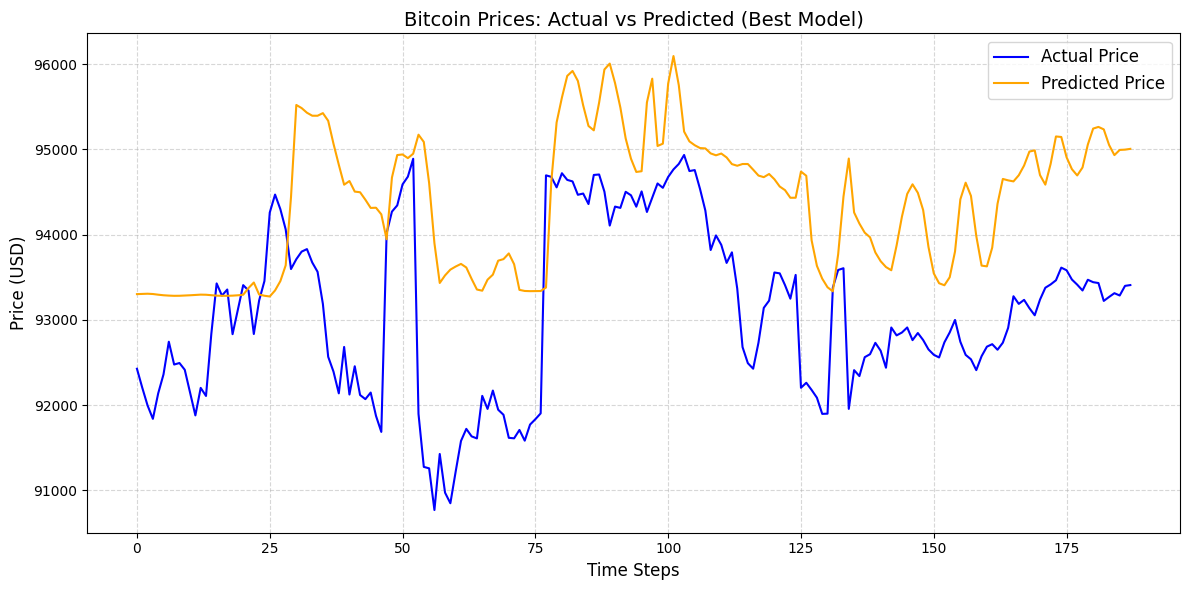

                  Time  Predicted Price (USD)
0  2024-11-29 00:00:00           94985.968750
1  2024-11-29 01:00:00           95196.234375
2  2024-11-29 02:00:00           95374.117188
3  2024-11-29 03:00:00           95562.429688
4  2024-11-29 04:00:00           95728.476562
5  2024-11-29 05:00:00           95809.882812
6  2024-11-29 06:00:00           95850.375000
7  2024-11-29 07:00:00           95839.648438
8  2024-11-29 08:00:00           95785.320312
9  2024-11-29 09:00:00           95719.281250
10 2024-11-29 10:00:00           95655.460938
11 2024-11-29 11:00:00           95665.257812
12 2024-11-29 12:00:00           95757.109375
13 2024-11-29 13:00:00           95867.632812
14 2024-11-29 14:00:00           95929.296875
15 2024-11-29 15:00:00           95911.195312
16 2024-11-29 16:00:00           95830.273438
17 2024-11-29 17:00:00           95718.117188
18 2024-11-29 18:00:00           95640.851562
19 2024-11-29 19:00:00           95585.453125
20 2024-11-29 20:00:00           9

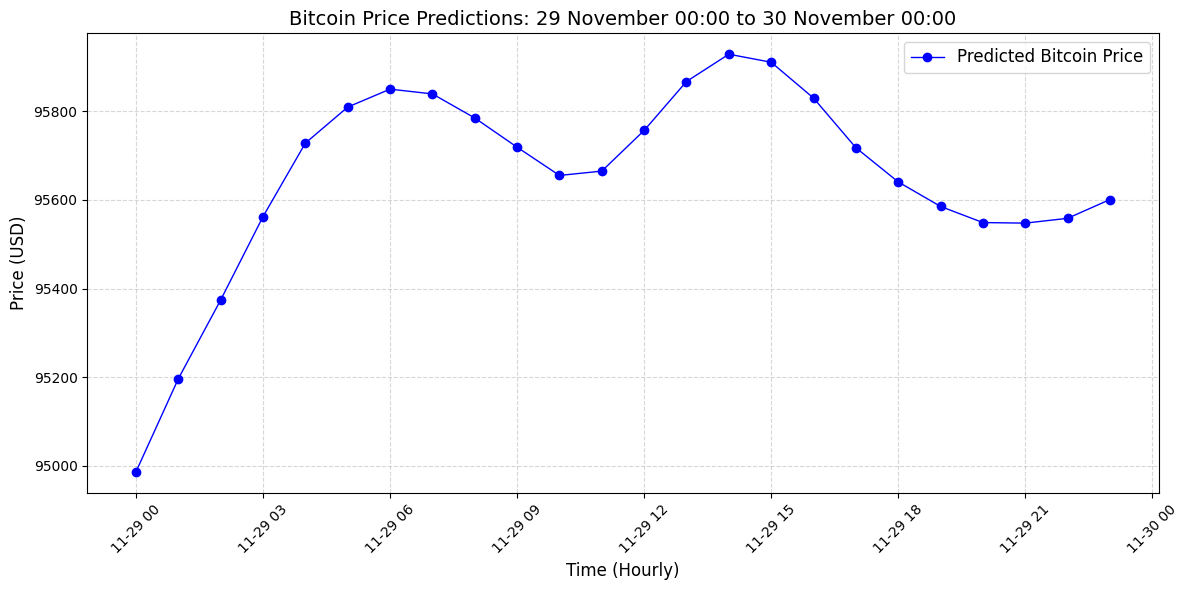

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Step 1: Load and preprocess the data
df = pd.read_csv('bitcoin.csv')  # Replace with your file path
df['Waktu'] = pd.to_datetime(df['Waktu'])  # Ensure 'Waktu' is datetime
df.set_index('Waktu', inplace=True)
prices = data['Harga_Penutupan'].values.reshape(-1, 1)  # Replace 'Harga_Penutupan' with your price column name

# Normalize the prices
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Step 2: Create sequences
sequence_length = 50  # Use the same sequence length as used in the tuning process

def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x, y = create_sequences(prices_scaled, sequence_length)

# Split into training and testing datasets
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Reshape for LSTM input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Step 3: Define the best model based on the optimal hyperparameters
best_model = Sequential([
    Bidirectional(LSTM(192, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(LSTM(224, activation='tanh', return_sequences=False)),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Fix: Compile the model with the optimizer and learning rate
optimizer = Adam(learning_rate=0.005589257943589798)
best_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Step 4: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = best_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 5: Evaluate the model on test data
y_pred_scaled = best_model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred_scaled)  # Reverse scaling to original prices
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"Mean Absolute Error (Best Model): {mae}")

# Step 6: Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Price', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Price', color='orange')
plt.title('Bitcoin Prices: Actual vs Predicted (Best Model)', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Step 7: Make predictions for the next 24 hours
last_sequence = prices_scaled[-sequence_length:].reshape(1, sequence_length, 1)

future_steps = 24  # Predict for the next 24 hours
predicted_prices_scaled = []
for _ in range(future_steps):
    prediction = best_model.predict(last_sequence, verbose=0)
    predicted_prices_scaled.append(prediction[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Reverse scaling for the predictions
predicted_prices = scaler.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1))

# Create timestamps for the next 24 hours
start_time = pd.Timestamp("2024-11-29 00:00:00")  # Adjust the date as needed
future_times = [start_time + pd.Timedelta(hours=i) for i in range(future_steps)]

# Combine predictions with timestamps
predictions_df = pd.DataFrame({
    'Time': future_times,
    'Predicted Price (USD)': predicted_prices.flatten()
})

# Display the predictions
print(predictions_df)

# Plot the predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Time'], predictions_df['Predicted Price (USD)'], marker='o', label='Predicted Bitcoin Price', color='blue', linewidth=1)
plt.title('Bitcoin Price Predictions: 29 November 00:00 to 30 November 00:00', fontsize=14)
plt.xlabel('Time (Hourly)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


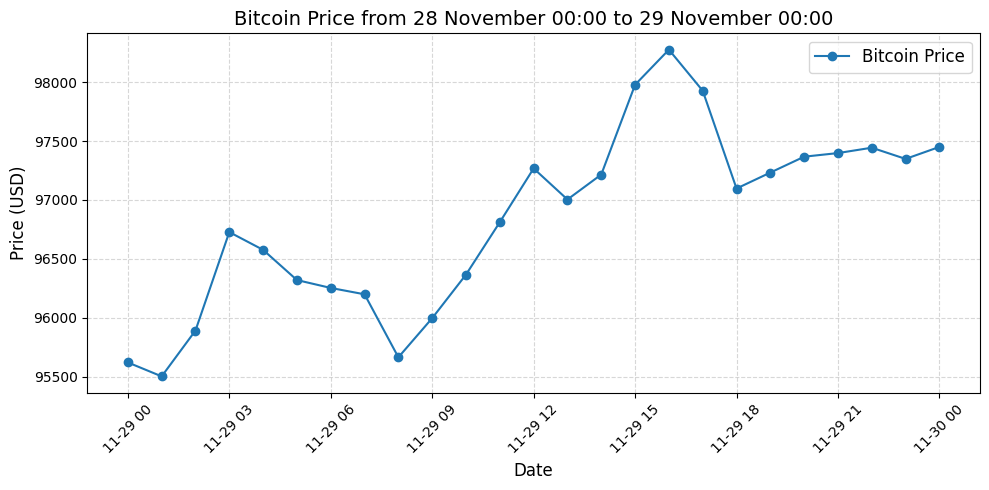

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fetch hourly data from CoinCap API
url = "https://api.coincap.io/v2/assets/bitcoin/history?interval=h1"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to fetch data from API. Status code:", response.status_code)
    exit()

# Step 2: Convert API response to DataFrame
prices = pd.DataFrame(data['data'])
prices['date'] = pd.to_datetime(prices['date'])  # Convert date string to datetime
prices['priceUsd'] = prices['priceUsd'].astype(float)  # Convert price to float

# Step 3: Filter data for the range 27 November 12:00 to 28 November 12:00
start_time = "2024-11-29T00:00:00Z"
end_time = "2024-11-30T00:00:00Z"
filtered_prices = prices[(prices['date'] >= start_time) & (prices['date'] <= end_time)]

# Step 4: Plot the data
plt.figure(figsize=(10, 5))
plt.plot(filtered_prices['date'], filtered_prices['priceUsd'], marker='o', label="Bitcoin Price")
plt.title("Bitcoin Price from 28 November 00:00 to 29 November 00:00", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
